# Monte-Carlo method

## Finding distributions and statistical properties using MC

As we see in previous lecture, we can  find estimations for mean and (biased) variance of a black-box function $f$ using a huge number of implementations of input variable $X=\{x_1,\,x_2,\,\ldots,\,x_N\}$

$$
\mathbb E f \approx \overline f=\frac1N\sum_{i=1}^Nf(x_i)
$$
$$
\text{Var }f \approx \frac1N\sum_{i=1}^N\bigl(f(x_i)-\overline f\bigr)^2
$$

We can find an approximate distribution of $f$ by a such type of simultaion.

Simple demonstration.

Consider a "complex" function
$$
f(x)=\sin\bigl(2\pi x\bigr)\cos\bigl(0.75(x+3)\pi\bigr)
$$

Let's plot a histogram of the distribution of the points
$$
\{f(x_1),\,f(x_2),\,\ldots,\,f(x_n)\}
$$
where each $\{x_i\}_{i=1}^n$ is sampled independently from the normal distribution
$$
x_i\sim\mathcal N\left(0,\sigma^2\right),\quad \sigma=1/5
$$

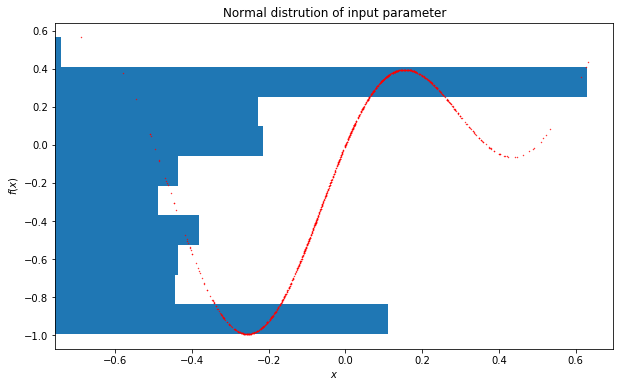

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def complex_func(x):
    return np.sin(2.0*x*np.pi)*np.cos(0.75*(x+0.3)*np.pi)

n = int(1e3)
x = np.random.randn(n)/5.0
y = complex_func(x)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,1,1)
ax2 = fig.add_axes(ax1.get_position(), frameon=False)

ax1.hist(y, orientation='horizontal');
ax2.plot(x, y, 'r.', ms=0.8);
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
ax1.set_xticks([])
ax1.set_yticks([])
plt.title('Normal distrution of input parameter')
plt.show()

And the same thing, but each $x_i$ has continuous uniform distribution
$$
x_i\sim\mathcal U(-1/2,\,1/2)
$$

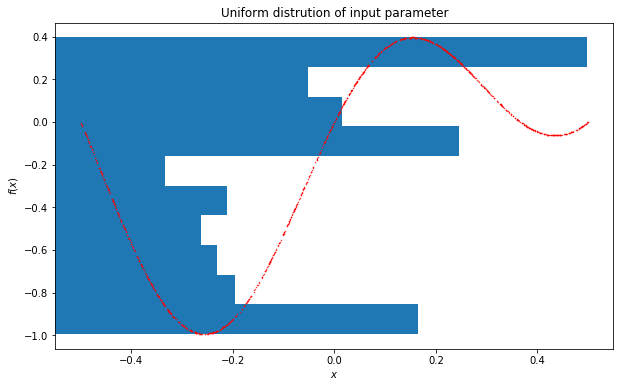

In [2]:
x = np.random.rand(n) - 0.5
y = complex_func(x)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,1,1)
ax2 = fig.add_axes(ax1.get_position(), frameon=False)

ax1.hist(y, orientation='horizontal');
ax2.plot(x, y, 'r.', ms=0.8);
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
ax1.set_xticks([])
ax1.set_yticks([])
plt.title('Uniform distrution of input parameter')
plt.show()

## Integral estimation

Consider a simple example with function on 1 variable.

Let $0\leq f(x)\leq1$, $x\in[0,\,1]$ and we need to find
$$
I=\int\limits_0^1f(x)\,dx.
$$

In the Monte-Carlo approach we sample a unit square $[0,\,1]\times [0,\,1]$ with quasi-random points sequence $\mathcal X = \{(x_i\,y_i)\}_1^N$.
Then the value of the integral $I$ is approximately equal to the ratio of the number of points <span class="mark">under</span> the graph of the function to the total number of points
$$
I\approx \frac1N \#\{(x_i,\,y_i)\in\mathcal X\colon f(x_i)>y_i\}
$$

In [3]:
def f(x):
    return np.sin(x*np.pi)

f.exact_val = 1.0/np.pi*(-np.cos(np.pi) + np.cos(0))

def MC_integr(f, n=2**12):
    plot_x = np.linspace(0, 1, 2**10)


    Xset = np.random.rand(n, 2)
    idx_under = f(Xset[:, 0]) > Xset[:, 1]
    approx_val = float(len(Xset[idx_under]))/len(Xset)
    error = np.abs(approx_val - f.exact_val)

    plt.figure(figsize=(10,6))
    plt.plot(plot_x, f(plot_x))
    
    plt.plot(Xset[idx_under, 0], Xset[idx_under, 1], 'r.', Xset[~idx_under, 0], Xset[~idx_under, 1], 'k.', ms=2);
    plt.title('Number of points $n=${}'.format(n))
    print("I ≈ {}, exact value = {}, error = {}".format(approx_val , f.exact_val, error ) )


I ≈ 0.645263671875, exact value = 0.6366197723675814, error = 0.008643899507418618


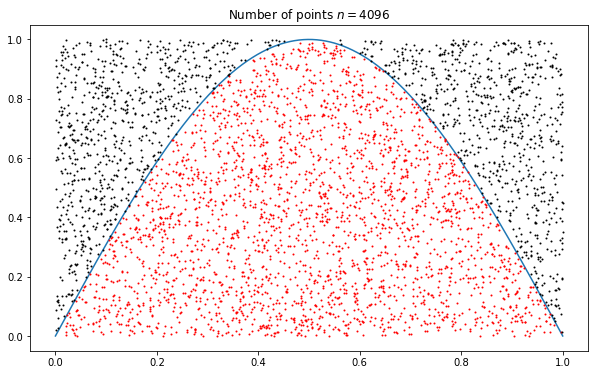

In [4]:
MC_integr(f, n=2**12);

Let find how error depends on number of samples

In [5]:
def MC_error(f, Xset):
    idx_under = f(Xset[:, 0]) > Xset[:, 1]
    return np.abs(float(len(Xset[idx_under]))/len(Xset) - f.exact_val)

errors = np.array([(N**2, MC_error(f, np.random.rand(N**2, 2)) ) for N in range(3, 1000, 10)])


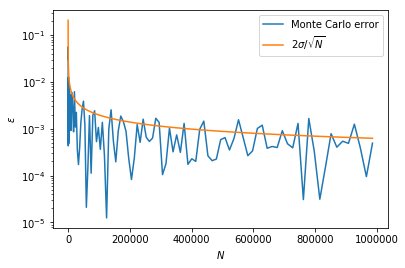

In [6]:
plt.plot(errors[:, 0], errors[:, 1], errors[:, 0], 2*0.31/errors[:, 0]**0.5)
plt.xlabel('$N$')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.legend(['Monte Carlo error', r'$2\sigma/\sqrt{N}$']);

Consider a [Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence) which is low-discrepancy

In [7]:
from numba import jit

@jit
def halton(n, dim, start=0, bases=np.array([2,3])):
    """RETURNS Halton sequence"""

    r = np.zeros([n, dim])

    prime_inv_s = 1.0 / bases[:dim]

    for k, i in enumerate(range(start, start + n)):

        t = np.full(dim, i, dtype=int)

        prime_inv = np.copy(prime_inv_s)
        while 0 < np.sum(t):
            for j in range (0, dim):
                d = t[j] % bases[j]
                r[k, j] += d * prime_inv[j]
                prime_inv[j] /= bases[j]
                t[j] //= bases[j]

    return r

<ipython-input-7-a98b73d77ffa>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "halton" failed type inference due to: Invalid use of Function(<built-in function zeros>) with argument(s) of type(s): (list(int64))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at <ipython-input-7-a98b73d77ffa> (7)


File "<ipython-input-7-a98b73d77ffa>", line 7:
def halton(n, dim, start=0, bases=np.array([2,3])):
    <source elided>

    r = np.zeros([n, dim])
    ^

  @jit
<ipython-input-7-a98b73d77ffa>:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "halton" failed type inference due to: cannot determin

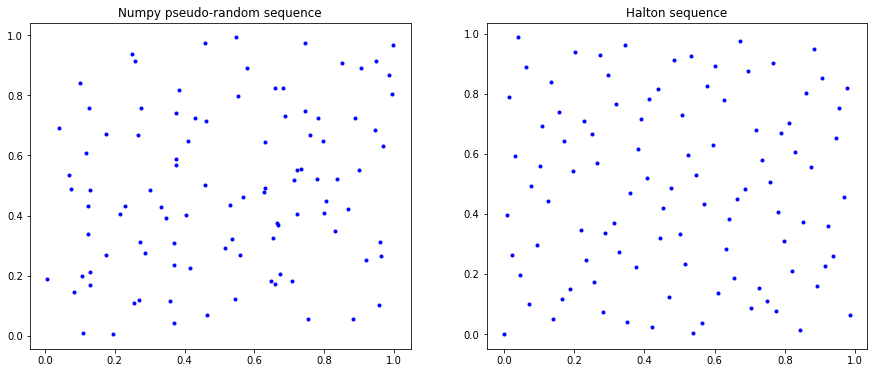

In [8]:
pnts_H = halton(100, 2)
pnts_r = np.random.rand(100, 2)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(pnts_r[:, 0], pnts_r[:, 1], 'b.');
ax1.set_title('Numpy pseudo-random sequence');
ax2.plot(pnts_H[:, 0], pnts_H[:, 1], 'b.');
ax2.set_title('Halton sequence');

In [9]:
max_sqrt_N = 200
halton_seq = halton(max_sqrt_N**2, 2)
errors_Halton = np.array([(N**2, MC_error(f, halton_seq[:N**2]) ) for N in range(3, max_sqrt_N, 5)])


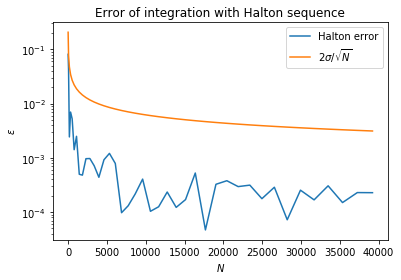

In [10]:
plt.plot(errors_Halton[:, 0], errors_Halton[:, 1], errors_Halton[:, 0], 2*0.31/errors_Halton[:, 0]**0.5)
plt.xlabel('$N$')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.title("Error of integration with Halton sequence");
plt.legend(['Halton error', r'$2\sigma/\sqrt{N}$']);

### Importance sampling
A greater contribution to the value of the integral is given by the points at which the function takes on a larger value.
The next idea is to use a distribution whose probability density is close to the value of the function.

Let the random variable $\xi$ have a distribution $\rho$. In this approach we approximately find the mean of the following value
$$
\mathbb E \left(\frac f\rho\right)=\int\limits_0^1\frac{f(x)}{\rho(x)}\rho(x)\,dx\approx\frac1N\sum_{i=1}^N\frac{f(\xi_i)}{\rho(\xi_i)}
$$
where $\{\xi_1,\,\xi_2,\,\ldots,\,\xi_N\}$ are independent realizations of $\xi$.

First, we need to model a random value with the given distribution $\rho$. For the simplicity, let this distribution be piecewise constant.

Two important methods for generating a random variable with a given distribution will be considered below, now we will use the following method. We split an interval, the random value belongs to, into equal subintervals. Then, we randomly choose one of these subintervals with a probability proportional to the $f(h_i)$, where $h_i$ is the center of the interval. Numpy function *random.choice* helps us. In the end, we choose a random point uniformly distributed in the chosen interval. 

In [11]:
@jit
def piecewise_distrib(f, m, N, interval=(0,1)):
    """RETURN N samples of the random variable
       INPUT  m sets the number of intervals
       Only for demonstrations purposes. Never use this func in real calculations!
    """
    intervls = np.linspace(interval[0], interval[1], m+1)
    intervls = np.vstack((intervls[:-1], intervls[1:])).T
    p = f(np.mean(intervls, axis=1))
    p /= p.sum()
    xi = np.empty(N)
    for i in range(N):
        cur_intrvl = intervls[np.random.choice(np.arange(len(intervls)), 1, p=p)][0]
        xi[i] = np.random.uniform(cur_intrvl[0], cur_intrvl[1])   
        
    return xi

def make_rho(f, m, interval=(0,1)):
    x0, x1 = interval
    intervls = np.linspace(x0, x1, m+1)
    intervls = np.vstack((intervls[:-1], intervls[1:])).T
    p = f(np.mean(intervls, axis=1))
    p /= p.sum()
    ln = x1 - x0
    
    def rho(x):
        if x0 >= x or x >= x1:
            return 0.0
        return p[int(np.floor((x-x0)*m/ln))]*m/ln
    
    return np.vectorize(rho, signature="()->()")

# Compile it
piecewise_distrib(f, 3, 10);

<ipython-input-11-6ca01ffe4dd2>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "piecewise_distrib" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-11-6ca01ffe4dd2> (7)

File "<ipython-input-11-6ca01ffe4dd2>", line 7:
def piecewise_distrib(f, m, N, interval=(0,1)):
    <source elided>
    """
    intervls = np.linspace(interval[0], interval[1], m+1)
    ^

  @jit
<ipython-input-11-6ca01ffe4dd2>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "piecewise_distrib" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-11-6ca01ffe4dd2>", line 12:
def piecewise_distrib(f, m, N, interval=(0,1)):
    <source elided>
    xi = np.empty(N)
    for i in range(N):
    ^

  @jit
/Users/g.ryzhakov/anaconda2/envs/py3/lib/python3.6/site-packages/numba/compiler.py:742: N

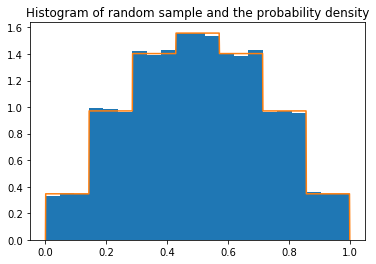

In [12]:
num_of_intervals = 7 # Number of intervals we divide to
xis = piecewise_distrib(f, num_of_intervals, 100000)
plt.hist(xis, bins=3*num_of_intervals, range=(0,1), density=True);
rho = make_rho(f, num_of_intervals)
x = np.linspace(0, 1, 2**10)
plt.plot(x, rho(x));
plt.title('Histogram of random sample and the probability density');

Now plot the error of the integral estimation with this approach

In [13]:
max_sqrt_N = 200
pd_seq = piecewise_distrib(f, num_of_intervals, max_sqrt_N**2)
errors_pd = np.array([(   N**2, np.abs(f.exact_val - np.mean(f(pd_seq[:N**2])/rho(pd_seq[:N**2])) )   ) for N in range(3, max_sqrt_N, 5)])


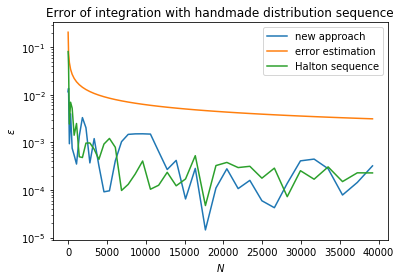

In [14]:
plt.plot(errors_pd[:, 0], errors_pd[:, 1], errors_pd[:, 0], 2*0.31/errors_pd[:, 0]**0.5, errors_Halton[:, 0], errors_Halton[:, 1])
plt.xlabel('$N$')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.title("Error of integration with handmade distribution sequence");
plt.legend(['new approach', 'error estimation', 'Halton sequence']);

# Generating samples with the given distribution

Above we have shown how to build samples of the random value with the piecewise constant probability density function.

In many applications, it may be necessary to construct a sample from the statistical population with a given distribution. Now we will show two ways how to do this.

## Rejection sampling

Suppose we want to sample a random variable with the probability density function $\rho$.
First, we seek for another random value $\xi$ which we are able to sample, with the probability density function $\omega$ such that $\rho(x)\leq c\cdot\omega(x)$ for some constant $c\geq0$ and any $x$ from the function $\rho$ domain. 

The sampling process is the following.
First, we take a sample $x$ of $\xi$. Then, we take a sample $y$ of the random value $\mathcal U$ uniformly distributed on the  interval $[0, \,c\cdot\omega(x)]$. To do this we can take a sample of the random value unoformly distributed on the interval $[0, \,1]$ and then multiply it by $c\cdot\omega(x)$.
Then, if the relation $y<\rho(x)$ holds, we add $x$ to the sample. 

We will illustrate this process on the example of sampling the random variable with piecewise constant probability density function from above. We will use normal distribution as value $\xi$. 

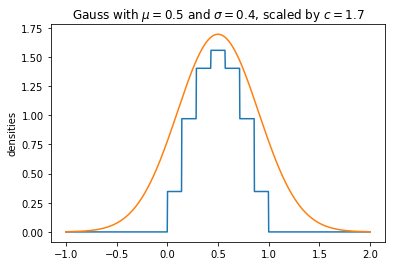

In [15]:
from scipy.special import erf
def gauss(x, mu=0, sigma=1):
    return 1.0/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )

c = 1.7;
mu = 0.5
sigma = 0.4
x = np.linspace(-1, 2, 2**10)
plt.plot(x, rho(x), x, c*gauss(x, mu, sigma));
plt.ylabel("densities");
plt.title('Gauss with $\mu={}$ and $\sigma={}$, scaled by $c={}$'.format(mu, sigma, c));

In [16]:
# Process
res   = []
res_y = []
reject   = []
reject_y = []
n = 35 # number of samples
while len(res) < n:
    x = np.random.normal(mu, sigma)
    y = np.random.rand()
    y *= c*gauss(x, mu, sigma)
    if y < rho(x):
        res.append(x)
        res_y.append(y)
    else:
        reject.append(x)
        reject_y.append(y)

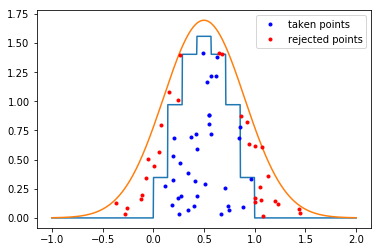

In [17]:
x = np.linspace(-1, 2, 2**10)
plt.plot(x, rho(x), x, c*gauss(x, mu, sigma));
plt.plot(res, res_y, 'b.', label='taken points');
plt.plot(reject, reject_y, 'r.', label='rejected points');
plt.legend();

**advantages**
- also works in multi-dimensional case

**limitations**

- needs to have a generator of samples of another random value
- can model only random values with probability density function
- if $\rho$ and $\omega$ differs much, many points can be rejected. This leads to a long time of sampling

## Inverse transform sampling
This method is based on the following fact. Let the cumulative distribution function (CDF) $F$ of some random value is strictly monotone and continuous, and therefore have the inverse $F^{-1}$. Let random value $\def\u{\xi}\u$ is uniformly distributed on $(0,\,1)$: $\u\sim\mathcal U(0,\,1)$.
Then the random value $F^{-1}(\u)$ have function $F$ as CDF.

Indeed,
$$
\mathbb P(F^{-1}(\u) \leq x) =
\mathbb P(\u \leq F(x))=
F(x).
$$
Here we use the fact, that if a function $f$ is  strictly monotone, then $\mathbb P(\mathcal X < x)=\mathbb P(f(\mathcal X) < f(x))$.

The statement holds true if $F(x)$ is not strictly monotone and/or discontinuous, in this case then we take by the definition that $F^{-1}(u) = \min\{x\colon F(x)\leq u\}$ (<font color="red">Note, there is an error in the previous definition. What is the right formula?</font>). This definition is correct because CDFs are  monotone and right-continuous.

$\color{red}{\text{Q: Why do all work in this case?}}$

The sampling generation process is very simple. We take a uniformly distributed sample
$\{\xi_1,\,\xi_2,\,\ldots,\,\xi_n\}$ and return $\{F^{-1}(\xi_1),\,F^{-1}(\xi_2),\,\ldots,\,F^{-1}(\xi_n)\}$.

We will illustrate this method on the same piecewise constant probability density function.

In [18]:
def make_piecewise_CDF(f, m, interval=(0,1)):
    """RETURN CDF
       INPUT  m sets the number of intervals
    """
    
    x0, x1 = interval
    d = x1 - x0
    intervls = np.linspace(interval[0], interval[1], m+1)
    intervls = np.vstack((intervls[:-1], intervls[1:])).T
    p = f(np.mean(intervls, axis=1))
    p /= p.sum()
    b = np.zeros(m)
    b[1:] = p.cumsum()[:-1]  - np.arange(1, m)*p[1:]
        
    def CDF(x_raw):
        x = (x_raw - x0)/d
        if 0 >= x:
            return 0.0
        if x >= 1:
            return 1.0
        
        i = int(np.floor(x*m))
        return b[i] + p[i]*x*m
    
    return np.vectorize(CDF, signature="()->()")

def make_piecewise_CDF_inv(f, m, interval=(0,1)):
    """RETURN inverse CDF"""

    x0, x1 = interval
    d = x1 - x0
    CDF = make_piecewise_CDF(f, m, interval)
    nodes = np.linspace(x0, x1, m+1)
    
    x_coords = CDF(nodes)
    intervls = np.vstack((x_coords[:-1], x_coords[1:])).T
    
    def CDF_inv(x):
        if x<0 or x>1:
            return None
        
        for ni, (l, r) in enumerate(intervls):
            if l <= x <= r:
                # line passing through points (l, nodes[ni]) and (r, nodes[ni+1])
                y0, y1 = nodes[ni], nodes[ni+1]
                return (-r*y0 + x*(y0 - y1) + l*y1)/(l - r)
        
    return np.vectorize(CDF_inv, signature="()->()")
    

In [19]:
f_s = lambda x: f(x/1.5)
num_of_intervals = 5
interval = (0, 1.5)
CDF     = make_piecewise_CDF(f_s, num_of_intervals, interval)
CDF_inv = make_piecewise_CDF_inv(f_s, num_of_intervals, interval)
rho     = make_rho(f_s, num_of_intervals, interval)

x = np.linspace(-0.35, 1.85, 2**11)
dot_x = np.linspace(0, 1.4, 2)
pnt_angle = np.linspace(interval[0], interval[1], num_of_intervals+1)

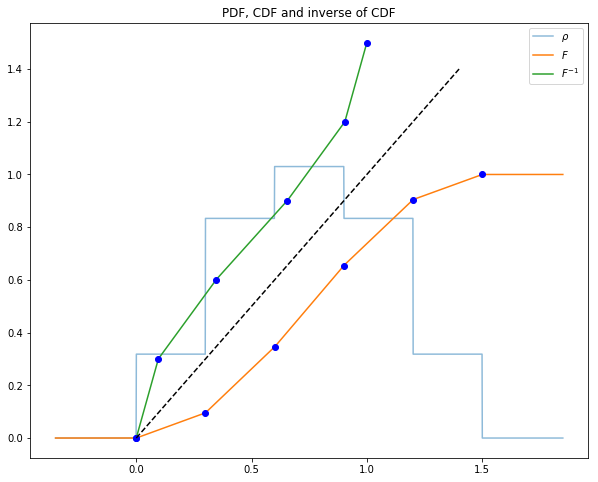

In [20]:
plt.figure(figsize=(10,8))
plt.plot(x, rho(x), alpha=0.5)
plt.plot(x, CDF(x))
plt.plot(x, CDF_inv(x))
plt.plot(pnt_angle, CDF(pnt_angle), 'bo');
plt.plot(CDF(pnt_angle), pnt_angle, 'bo');
plt.plot(dot_x, dot_x, 'k--')
plt.legend([r'$\rho$', '$F$', '$F^{-1}$']);
plt.title('PDF, CDF and inverse of CDF');

In this case, the CDF is continuous and strictly monotone in the intrval $[0,\,1.5]$, so the graph of the inverse function is a reflection of the graph of $F$ on this interval with respect to the line $y=x$.

Let's perform the samlpling process

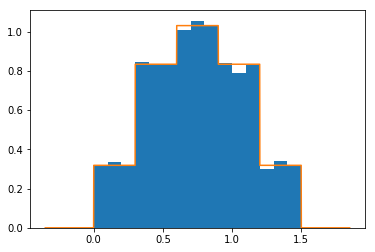

In [21]:
xis = CDF_inv(np.random.rand(10000))
plt.hist(xis, bins=3*num_of_intervals, range=(0,1.5), density=True);
plt.plot(x, rho(x));

One of the **advantages** of inverse transform sampling is that we can use this method when PDE does not exist, for example, in the case with discrete part of the distribution.

Consider the simplest case, when we have several outcomes $\{x_1,\,x_2,\,\ldots,\,x_n\}$ with the given probabilities $\{p_1,\,p_2,\,\ldots,\,p_n\}$, $\sum\limits_{i=1}^np_i=1$.

CDF is discontinuous and piecewise constant in this case.

In [22]:
outcomes = np.array([1, 2, 4])
p = np.array([0.25, 0.35, 0.4])

def CDF_(x):
    F = 0.0
    for i, xi in enumerate(outcomes):
        if x > xi:
            F += p[i]

    return F

CDF_discrete = np.vectorize(CDF_, signature="()->()")

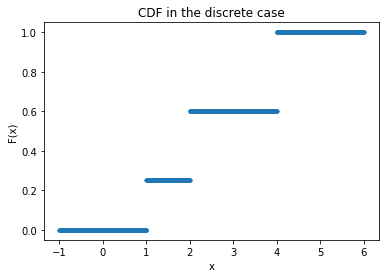

In [23]:
x = np.linspace(-1, 6, 2**11)
plt.plot(x, CDF_discrete(x), '.');
plt.ylabel('F(x)')
plt.xlabel('x')
plt.title('CDF in the discrete case');

But the inverse function $F^{-1}$ still exists according to our definition

In [24]:
F_vals = CDF_discrete(outcomes)
print ("Values of F (less 1): {}".format(F_vals))

def CDF_discrete_inv_(x):
    if x<0 or x>1:
        return None

    return outcomes[F_vals[1:].searchsorted(x, side='right')]
        
CDF_discrete_inv = np.vectorize(CDF_discrete_inv_, signature="()->()")

Values of F (less 1): [0.   0.25 0.6 ]


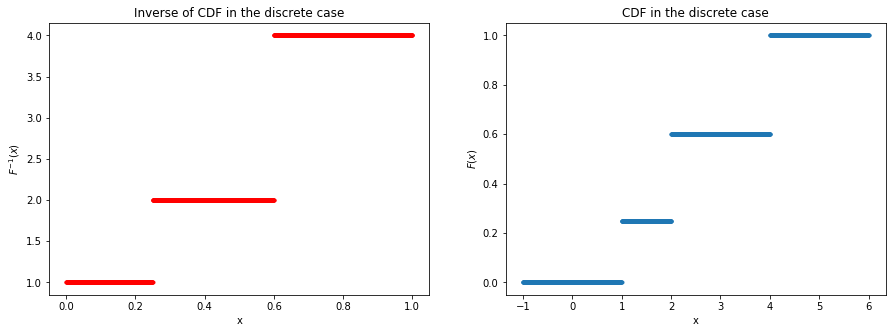

In [25]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
x = np.linspace(0, 1, 2**11)
ax1.plot(x, CDF_discrete_inv(x), 'r.');
ax1.set_title('Inverse of CDF in the discrete case');
ax1.set_ylabel('$F^{-1}(x)$')
ax1.set_xlabel('x')

x = np.linspace(-1, 6, 2**11)
ax2.plot(x, CDF_discrete(x), '.');
ax2.set_ylabel('$F(x)$')
ax2.set_xlabel('x')
ax2.set_title('CDF in the discrete case');

Note, that the lengths of constancy intervals are $(0.25,\,0.35,\, 0.4)$, they coincide with probabilities $\{p_i\}$.

Let's take a few sample of the distribution

In [26]:
from collections import Counter
xis = CDF_discrete_inv(np.random.rand(1000))
for x in outcomes:
    print ('The outcome {} has a frequency {}.'.format(x, float(Counter(xis)[x])/len(xis)))

The outcome 1 has a frequency 0.254.
The outcome 2 has a frequency 0.353.
The outcome 4 has a frequency 0.393.


We can summarise the method in this (discrete) case: split the interval $(0,\,1)$ on the subintervals of the length, equal to the probabilities $\{p_i\}$, sample the uniformily distributed random value, find the index $i$ of the interval the value hits, and return $x_i$. Numpy function *random.choice* works in the similar way.

**limitations**

- needs to know the inverse of the cumulative distribution function, but sometime it is hard to find CDF itself
- works only in 1-dimensional case